# Principal Component Analysis (PCA) in Python

## Introduction

This exercise is an introduction to principal component analysis in Python. The classical iris data set is used as an example. Check [here](https://en.wikipedia.org/wiki/Iris_flower_data_set) for an explanation.

Thanks to Jonas Attrup Rasmussen for providing the markdown version of the exercise.

## Learning Objectives

After completing this exercise, the student should be able to do the following:

1.  Use *NumPy* to read text files.
2.  Create a data matrix from a text file
3.  Organise measured data into a data matrix
4.  Compute the variance of a set of measurements  
5.  Compute the covariance between two sets of measurements
6.  Use the function *pairplot* from the *seaborn* package to visualise the covariance between multiple sets of measurements
7.  Compute the covariance matrix from multiple sets of measurements using matrix multiplications
8.  Compute the covariance matrix from multiple sets of measurements using the *NumPy* *cov* function.
9.  Compute the principal components using Eigenvector analysis (*NumPy* function *eig*).
10.  Visualize how much of the total of variation each principal component explain.
11.  Project original measurements into principal component space
12.  Use the function *pairplot* to visualise the covariance structure after projecting to principal component space.
13.  Compute the PCA using the *PCA* function from the *sci-kit learn* decomposition package.

## Getting the Data

Start by creating an exercise folder where you keep your Python data. Download the data from the data from [this repository](data/) and place them in this folder.

## Loading the data

We start by reading the data and in this example we only use the first 50 measurements from the same type of flower:

### Exercise 1  
Start by reading the data and create a data matrix `x`:

In [27]:
import numpy as np
in_dir = "../data/"
txt_name = "irisdata.txt"
iris_data = np.loadtxt(in_dir + txt_name, comments="%")
# x is a matrix with 50 rows and 4 columns
x = iris_data[0:50, 0:4]

Then check the data dimensions by writing:

In [2]:
n_feat = x.shape[1]
n_obs = x.shape[0]
print(f"Number of features: {n_feat} and number of observations: {n_obs}")

Number of features: 4 and number of observations: 50


We have 50 flowers and for each flower there are 4 measurements (features): sepal length, sepal width, petal length and petal width. Are your matrix dimensions correct?

## Explorative data analysis
### Exercise 2
To explore the data, we can create vectors of the individual feature:

In [ ]:
print(x.shape)

sep_l = x[:, 0]
sep_w = x[:, 1]
pet_l = x[:, 2]
pet_w = x[:, 3]

(50, 4)


Compute the variance of each feature like:

In [4]:
# Use ddof = 1 to make an unbiased estimate
var_sep_l = sep_l.var(ddof=1)
var_sep_w = sep_w.var(ddof=1)
var_pet_l = pet_l.var(ddof=1)
var_pet_w = pet_w.var(ddof=1)

do that for all the features.

### Exercise 3

Now compute the covariance:  
$$\sigma^2 = \frac{1}{N-1} \sum_i a_i b_i$$

between the sepal length and the sepal width. Please note that we use $N − 1$ instead of just $N$ in the computation of the covariance. The reason for this can be found in estimation theory. Also note that the covariance we compute is not equal to for example the Numpy `cov` function. It can, though, still tell us something about the data.

Compute the covariance between the sepal length and the petal length and compare it to the covariance between the sepal length and width. What do you observe?


In [9]:
###NOTE: it is uncentered covariance

N = x.shape[0]
cov = 1/(N-1)*(x.T@x)
print(cov)

cov_sep_l_pet_l = cov[0,2]
cov_sep_l_sep_w = cov[0,1]

print(cov_sep_l_pet_l, cov_sep_l_sep_w)

[[25.69571429 17.61        7.4844898   1.26693878]
 [17.61       12.13469388  5.12571429  0.86979592]
 [ 7.4844898   5.12571429  2.21122449  0.37306122]
 [ 1.26693878  0.86979592  0.37306122  0.07285714]]
7.484489795918369 17.610000000000003


So we find that we have a larger covariance between sepal length and width than between sepal length and petal width. This *could* make sense, as the sepal is the same leaf which probably has some sort of rule for shape whereas the relationship between sepal and petal may be less direct and conserved between flowers. 

But: it may also just be a scaling issue, look at the scale of sepals vs. petals, in reduced fashion by first considering the mean: 

In [14]:
print(sep_l.mean())
print(sep_w.mean())

print(pet_w.mean())
print(pet_l.mean())

#we note that sepals are way larger than petals in scale. As such, uncentered covariances between sepal measurements will tend to be larger. This may not be meaningful in real life 

5.006
3.428
0.24599999999999997
1.4620000000000002



### Exercise 4

As with image analysis, it is very useful to get a graphical understanding of the data and what structures are hidden in the them. For this, we will use the seaborn Python package that also used the pandas package. Take a look at Appendix A, at the end of the document, for installation instructions.

Import *seaborn* and *pandas*:

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 

Now let us get a closer look at the data structure using a *pairplot*:

<Figure size 640x480 with 0 Axes>

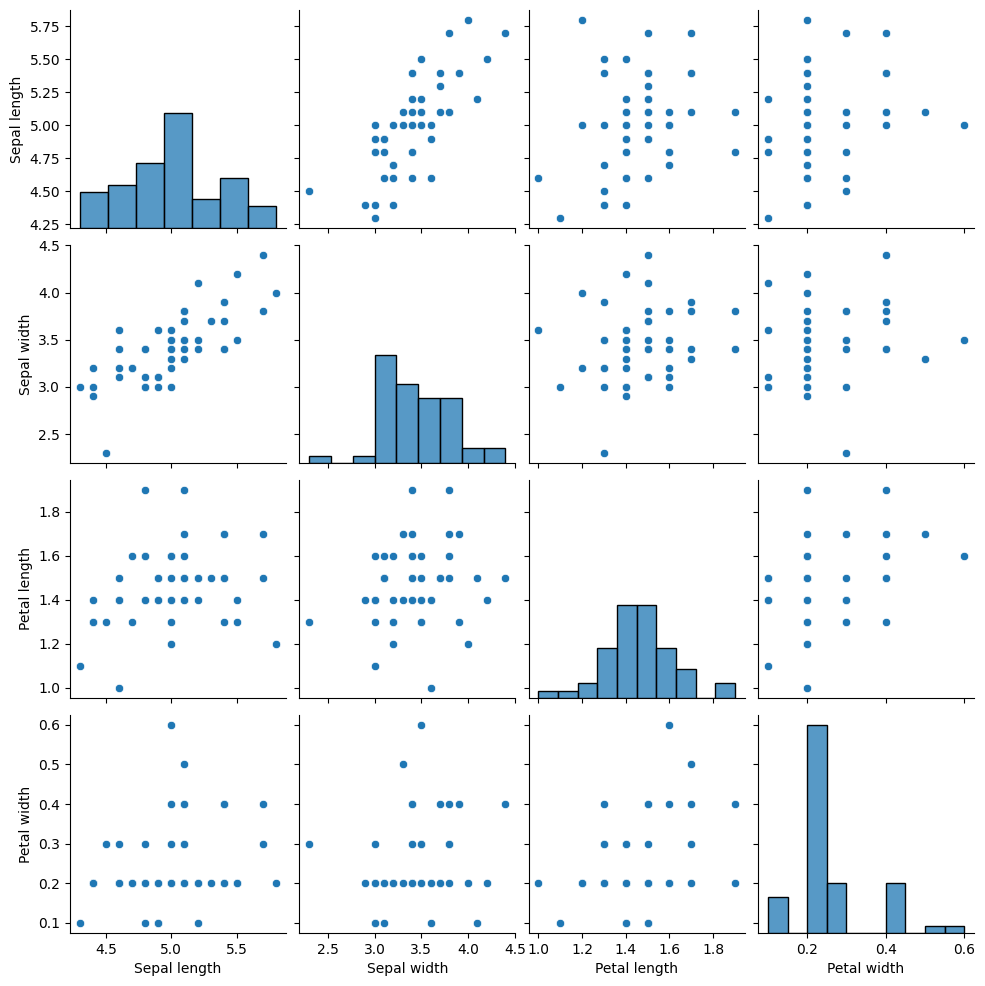

In [28]:
#x = pd.read_csv(in_dir+"irisdata.txt",sep="\t",comment="%", header=None, names = ["Sepal length", "Sepal width","Petal length", "Petal width"])
plt.figure() # Added this to make sure that the figure appear
# # Transform the data into a Pandas dataframe
d = pd.DataFrame(x, columns=["Sepal length", "Sepal width","Petal length", "Petal width"])
sns.pairplot(d)
plt.show()

What measurements are related and which ones are not-related? Can you recognise the results you found, when you computed the variance and covariance?

It seems sepal width and sepal length have a nice positive correlation which is somewhat linear. Sepal width to petal length could indeed have a somewhat positive correlation, albeit a small value. On the other hand, petal width seems fairly uncorrelated to other things except a minor positive correlation to petal length.
Confirms what we found earlier: look at matrix


In [29]:
print(cov)

[[25.69571429 17.61        7.4844898   1.26693878]
 [17.61       12.13469388  5.12571429  0.86979592]
 [ 7.4844898   5.12571429  2.21122449  0.37306122]
 [ 1.26693878  0.86979592  0.37306122  0.07285714]]



## PCA Analysis

We will do the principal component analysis (PCA) in two ways. First, a method combining several steps and finally using a dedicated pca library that does all at once.

### Exercise 5

In the first approach, we do the analysis step-wise. Start by subtracting the mean from the data:

In [31]:
mn = np.mean(x, axis=0)
data = x - mn
print(data.shape)

(50, 4)


Now compute the covariance matrix using: $$\mathbf{C}_\mathbf{X} = \frac{1}{N-1} \mathbf{X}^\text{T} \mathbf{X}$$
Remember to use the data, where the mean has been subtracted. You can use the NumPy function `matmul` to multiply two matrices together. Also remember to transpose data in one of the arguments to the function.

You can also use the NumPy function cov to compute the covariance matrix. Verify if the two approaches give the same result?



In [40]:
cov_cen = (data.T@data)/(N-1)
cov_np = np.cov(data.T)

print(f"{cov_cen}\n{cov_np}")
print(np.linalg.norm(cov_cen-cov_np,ord=np.inf)) #infinity norm gives us max divergence - we see that the difference boils down to numerics and machine precision

[[0.12424898 0.09921633 0.0163551  0.01033061]
 [0.09921633 0.1436898  0.01169796 0.00929796]
 [0.0163551  0.01169796 0.03015918 0.00606939]
 [0.01033061 0.00929796 0.00606939 0.01110612]]
[[0.12424898 0.09921633 0.0163551  0.01033061]
 [0.09921633 0.1436898  0.01169796 0.00929796]
 [0.0163551  0.01169796 0.03015918 0.00606939]
 [0.01033061 0.00929796 0.00606939 0.01110612]]
1.700029006457271e-16



### Exercise 6

Now you can compute the principal components using eigenvector analysis:

In [ ]:
values, vectors = np.linalg.eig(cov_cen) # Here cov is your covariance matrix.


print(values)
print(vectors) #columns of vectors is eigenvector
print(vectors.shape) #columns of vectors is eigenvector

[0.23645569 0.03691873 0.0267964  0.00903326]
[[ 0.6690784   0.59788401  0.43996277 -0.03607712]
 [ 0.73414783 -0.62067342 -0.27460747 -0.01955027]
 [ 0.0965439   0.49005559 -0.8324495  -0.23990129]
 [ 0.06356359  0.13093791 -0.19506751  0.96992969]]
(4, 4)


The values are the eigenvalues and the vectors are the eigenvectors (the principal components).

### Exercise 7

Lets examine some properties of the principal components. First try to find out how much of the total variation the first component explains?

In [54]:
values[0]/values.sum() * 100

np.float64(76.4723702306554)

You can also plot the amount of explained variation for each component:

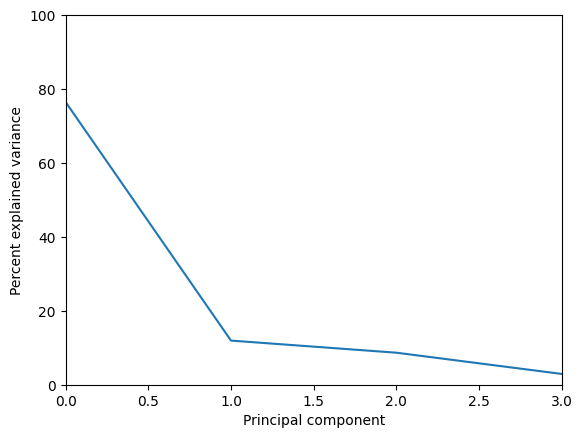

In [55]:
v_norm = values / values.sum() * 100
plt.plot(v_norm)
plt.xlabel("Principal component")
plt.ylabel("Percent explained variance")
plt.ylim([0, 100])
plt.xlim([0,3])
plt.show()

### Exercise 8

The data can be projected onto the PCA space by using the dot-product:

In [67]:
pc_proj = vectors.T.dot(data.T)
print(pc_proj.shape)
pc_proj_alt = data.dot(vectors).T #this formulation fits wikipedia and general signal processing textbooks better, but in general I don't understand why the format Rasmus uses diverges from common textbooks.
#preferrably we would just say T = data@vectors, T \in [N_obs x N_pca], and standard statistics practice is to hold datamatrix in form [n x n_feats]. 


(4, 50)


Try to use seaborns pairplot with the projected data? How does the covariance structure look?



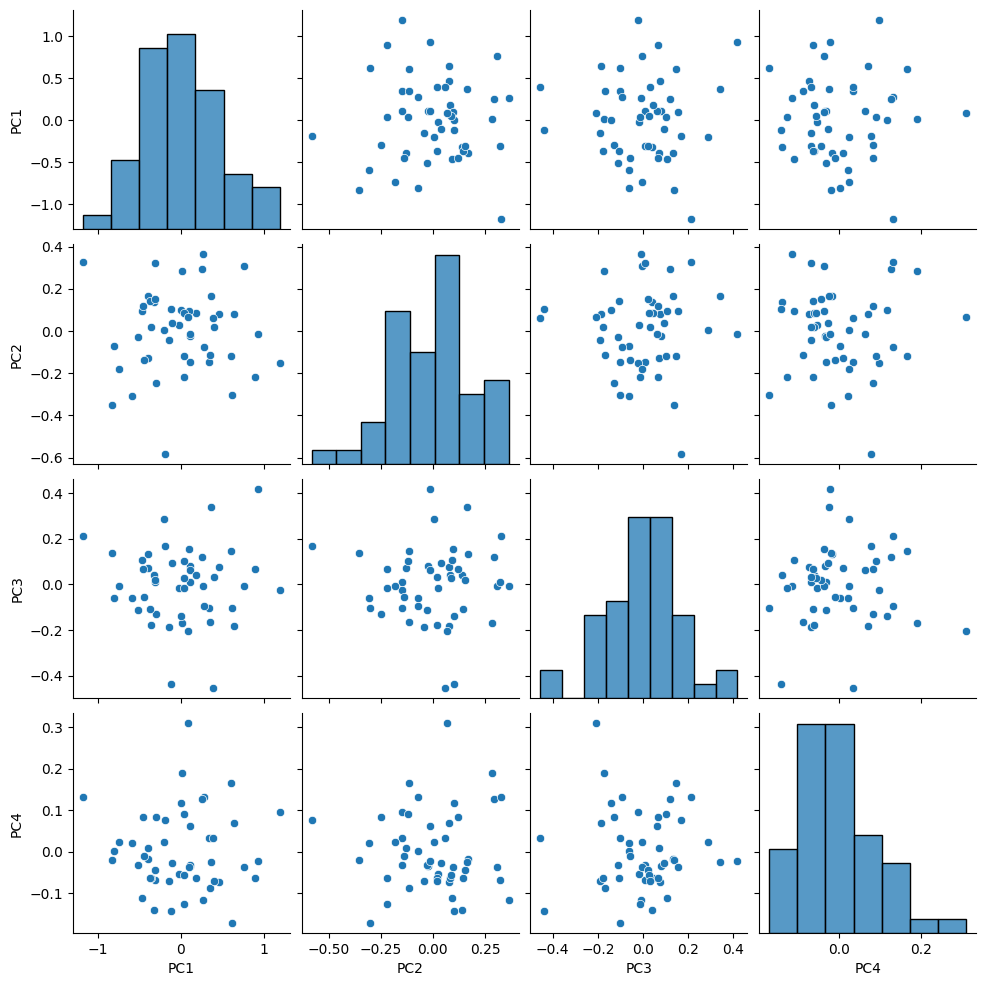

In [69]:
d_pca = pd.DataFrame(pc_proj.T, columns=["PC1", "PC2","PC3", "PC4"])
sns.pairplot(d_pca)

We notice that the correlation between principal component projections look very much like white noise. 

In [76]:
cov = np.cov(pc_proj)
print(cov)

#again, diagnoal elements should correspond to the variance 
print(np.diag(cov)/np.diag(cov).sum())
print(v_norm)

#and off-diagonals are small enough to be attributed to numerics/machine precision, i.e. it all makes sense :-))))

[[ 2.36455690e-01  1.92236971e-17  1.60044244e-18 -6.93357093e-19]
 [ 1.92236971e-17  3.69187324e-02  5.28473253e-17  4.66936830e-18]
 [ 1.60044244e-18  5.28473253e-17  2.67963986e-02 -8.46931682e-18]
 [-6.93357093e-19  4.66936830e-18 -8.46931682e-18  9.03326055e-03]]
[0.7647237  0.11939924 0.0866625  0.02921456]
[76.47237023 11.93992401  8.66624997  2.92145579]


### Direct PCA using the decompositions functions

The Python machine learning package sci-kit learn (*sklearn*) have several functions to do data decompositions, where PCA is one of them.

Let us explore if we get the same results using this function.  
Start by installing *sklearn* (see Appendix A) and importing the package:

In [77]:
from sklearn import decomposition

### Exercise 9

Read the data matrix as before, but do not subtract the mean. The procedure subtracts the mean for you.

The PCA can be computed using:

In [ ]:
pca = decomposition.PCA()
pca.fit(x)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_ #transposed 

data_transform = pca.transform(x) #still [N x 4]

print(values_pca)
print(exp_var_ratio)
print(f"{vectors_pca}\n{vectors}") #the components are transposed!


[0.23645569 0.03691873 0.0267964  0.00903326]
[0.7647237  0.11939924 0.0866625  0.02921456]
[[ 0.6690784   0.73414783  0.0965439   0.06356359]
 [-0.59788401  0.62067342 -0.49005559 -0.13093791]
 [-0.43996277  0.27460747  0.8324495   0.19506751]
 [-0.03607712 -0.01955027 -0.23990129  0.96992969]]
[[ 0.6690784   0.59788401  0.43996277 -0.03607712]
 [ 0.73414783 -0.62067342 -0.27460747 -0.01955027]
 [ 0.0965439   0.49005559 -0.8324495  -0.23990129]
 [ 0.06356359  0.13093791 -0.19506751  0.96992969]]
(50, 4)


Compare the results from the results you found using the step-by-step procedure. Some of the results are transposed - which ones?

## Appendix A - Package installations

**sklearn (sci-kit learn)**
(Further info [here](https://anaconda.org/anaconda/scikit-learn) and [here](https://scikit-learn.org/stable/))

```
activate course02503
conda install -c anaconda scikit-learn
```

**seaborn**
(Further info [here](https://anaconda.org/anaconda/seaborn) and [here](https://seaborn.pydata.org/))
```
activate course02503
conda install -c anaconda seaborn
```